# Test $\chi^2$ approximant le test exact de Fisher et introduction aux modèles de causalité de Pearl

Plan de la séance:

+ Distribution empirique de la $p$-value des tableaux de contingence $2\times 2$.

+ Généralisation aux tableaux $N \times M$ (notion de degré de liberté $k=(N-1)(M-1)$)

+ Approximation par le test du $\chi^2$ de paramètre $k$.

+ Notion d'indépendance conditionelle

+ Exemples de modélisation avec des hypothèses de dépendance

+ Modèles à variables en arguement ou d'affectation unique 

+ Graphe d'un Probabilistic Causal Model

+ Petits exemples de modèles causale probabilistes

+ Relations d'indépendances conditionelles et axiomes des graphoids

+ Condition suffisante à l'indépendance conditionnelle : la notion de $d$-séparation pour les graphes

+ Les niveaux Observer/Expérimenter/Imaginer de Pearl

+ Distinction entre le conditionnement _$P(...|X=x)$_ dans l'observation et de l'intervention _$do(X=x)$_ dans l'experimentation. 

+ Le __do-calculus__ pour identifier la partie finalement observable dans l'expérimentale (Enoncé approximatif du résultat de Pearl et Shpitser.

### Rappel de la séance précédente

In [1]:
import copy
import fractions
import math
import random
from typing import *

In [2]:
def XY():
    p = {(0,0): 0.4, (0,1):0.2, (1,0):0.3, (1,1):0.1}
    r = random.random()
    for xy in p:
        if p[xy] >= r:
            return xy
        r -= p[xy]
    assert(False)
    
maxX = 1
maxY = 1

In [3]:
def build_tableau_from_data(xys:List[Tuple[int]],maxX:int,maxY:int):
    tableau = { (x,y): 0 for x in range(maxX+2) for y in range(maxY+2)} # TODO
    for (x,y) in xys:
        tableau[x,y] += 1
        tableau[maxX+1,y] += 1
        tableau[x,maxY+1] += 1
        tableau[maxX+1,maxY+1] += 1
    return tableau    


def simulate_X_and_Y_for_tableau(XY:Callable[[],Tuple[int]],maxX:int,maxY:int,nb_tosses:int)-> Dict:
    xys = [XY() for _ in range(nb_tosses)]
    return build_tableau_from_data(xys,maxX,maxY)


def print_tableau(tableau:Dict)->None:
    (xs,ys) = ([ x for (x,_) in tableau],[ y for (y,_) in tableau])
    (maxX,maxY) = (max(xs),max(ys))
    print('<tableau>')
    for y in range(maxY+1):
        row = ''
        for x in range(maxX+1):
            if tableau[(x,y)] < 10: # XXX
                row += f'[ {tableau[(x,y)]}]'
            else:
                row += f'[{tableau[(x,y)]}]'
        print(row)
    print('</tableau>')

In [4]:
def list_all_2x2_tableaux_with_same_marginals(tableau:Dict):
    found_tableaux = [copy.deepcopy(tableau)] # TODO
    while min(found_tableaux[0][(0,0)],found_tableaux[0][(1,1)]) > 0:
        new_tableau = copy.deepcopy(found_tableaux[0])
        new_tableau[(0,0)] -= 1; new_tableau[(1,0)] += 1
        new_tableau[(0,1)] += 1; new_tableau[(1,1)] -= 1
        found_tableaux = [new_tableau]+found_tableaux
    while min(found_tableaux[-1][(1,0)],found_tableaux[-1][(0,1)]) > 0:
        new_tableau = copy.deepcopy(found_tableaux[-1])
        new_tableau[(0,0)] += 1; new_tableau[(1,0)] -= 1
        new_tableau[(0,1)] -= 1; new_tableau[(1,1)] += 1
        found_tableaux += [new_tableau]
    return found_tableaux

In [5]:
def hash_tableau(tableau:Dict)->Tuple[Tuple[int]]:
    n = max([x for (x,_) in tableau])
    m = max([y for (_,y) in tableau])
    return tuple([ tuple([ tableau[x,y] for x in range(n+1)]) for y in range(m+1)])

def dehash_tableau(hashed_tableau:Tuple[Tuple[int]]):
    n = len(hashed_tableau[0])
    m = len(hashed_tableau)
    return { (x,y): hashed_tableau[y][x] for x in range(n) for y in range(m)}
    
def canonical_box_of_balls_from_distribution(distribution):
    balls = []
    for z in range(len(distribution)):
        balls += distribution[z]*[z]
    return balls
    
def all_resamplings_of_tableau(tableau:Dict)->Dict:
    n = max([x for (x,_) in tableau]) #TODO
    m = max([y for (_,y) in tableau])
    k = tableau[n,m]
    X_marginal_distribution = tuple([ tableau[x,m] for x in range(n)])
    X_box_of_balls = canonical_box_of_balls_from_distribution(X_marginal_distribution)
    Y_marginal_distribution = tuple([ tableau[n,y] for y in range(m)])
    Y_box_of_balls = canonical_box_of_balls_from_distribution(Y_marginal_distribution)
    permutations_per_tableau = {}
    for a_ball_permutation in itertools.permutations(range(k)):
        xys = [ (X_box_of_balls[i],Y_box_of_balls[a_ball_permutation[i]]) for i in range(k)]
        its_tableau = build_tableau_from_data(xys,n-1,m-1)
        its_hashed_tableau = hash_tableau(its_tableau)
        if its_hashed_tableau not in permutations_per_tableau:
            print_tableau(its_tableau)
            permutations_per_tableau[its_hashed_tableau] = []
        permutations_per_tableau[its_hashed_tableau] += [a_ball_permutation]
    return permutations_per_tableau

In [6]:
def probability_of_a_tableau(tableau:Dict)->fractions.Fraction:
    n = max([x for (x,_) in tableau]) #TODO
    m = max([y for (_,y) in tableau])
    probability = 1
    for x in range(n+1):
        for y in range(m+1):
            if (x < m and y < n) or (x,y) == (m,n):
                probability /= fractions.Fraction(math.factorial(tableau[x,y]))
            else:
                probability *= fractions.Fraction(math.factorial(tableau[x,y]))
    return probability

In [7]:
def p_value_of_tableau(tableau):
    all_tableaux = list_all_2x2_tableaux_with_same_marginals(tableau)
    tableau_probability = probability_of_a_tableau(tableau)
    lower_probabilities = [ probability_of_a_tableau(t) for t in all_tableaux\
                           if probability_of_a_tableau(tableau) >= probability_of_a_tableau(t)]
    return sum(p for p in lower_probabilities)

## 1. Du test exact de Fisher au test approché du $\chi^2$

### Expérimentation sur la $p-$ value d'un tableau $2 \times 2$ de contingence

TODO 1.1:  Créer un tableau __tableau__ avec 300 tirages des paires réalisations de $(X,Y)$ donné par __XY()__. Lister dans __all_tableaux__ toutes les tableaux avec les mêmes marginales. En utilisant comme abscisse l'index d'un tableau dans la liste de tout les tableaux équivalents, tracer trois courbes:
- la $p$-value de chaque tableau
- la probabilité de chaque tableau
- le seuil constant 0.05=1/20 usuellement utilisé comme seuil de signifiance lors des tests de $p$-value.

In [8]:
nb_tosses = 300
tableau = simulate_X_and_Y_for_tableau(XY,maxX,maxY,nb_tosses)
print_tableau(tableau)

<tableau>
[113][88][201]
[62][37][99]
[175][125][300]
</tableau>


In [9]:
tableaux_with_same_marginals = list_all_2x2_tableaux_with_same_marginals(tableau)
nb_tabs = len(tableaux_with_same_marginals)
print(nb_tabs)


100


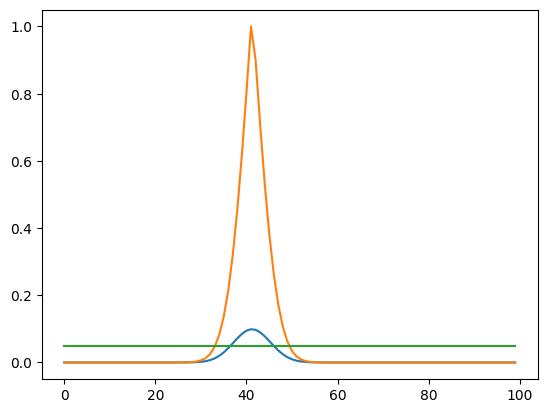

In [10]:
import matplotlib.pyplot as plt

xs = list(range(nb_tabs))
ys = [ probability_of_a_tableau(tableaux_with_same_marginals[x]) for x in range(nb_tabs) ]
zs = [ p_value_of_tableau(tableaux_with_same_marginals[x]) for x in range(nb_tabs) ]
us = [ 0.05 for _ in range(nb_tabs) ]
plt.plot(xs,ys)
plt.plot(xs,zs)
plt.plot(xs,us)
plt.show()
# print(ys.index(1))

### Généralisation aux tableaux $N \times M$

Le cas des matrices $2 \times 2$ est le plus petit, nous souhaitons étudiez sa généralisation au cas $n \times m$.

Une hypothèse forte sur les tableaux de contingence est que les lois marginales sont déterminée par le tableau.
Donc les autres tableau possibles doivent avoir les même sommes sur les lignes et les colonnes.
Nous allons étudier la possibilité de naviguer dans les tableaux de contingence possibles sous $H_0$ à l'aide de l'addition de sous-tableaux $2 \times 2$ sur les données (et non les sommes partielles) de la forme soit:
$$R_{i,j}^+:= \left(\begin{array}{cc} 
1 & -1 \\
-1 & 1 \\
\end{array}\right) \mbox{ et } 
R_{i,j}^-:= \left(\begin{array}{cc} 
-1 & 1 \\
1 & -1 \\
\end{array}\right)
$$
et appliqué sur les cases $(i,j),(i+1,j),(i,j+1),(i+1,j+1)$ de la partie donnée du tableau de contingence.

TODO 1.2: Synthétiser la présentation au tableau pour répondre aux questions suivantes. Quelle est le nombre de matrices $R_{i,j}^+$, aussi appelé plus tard le degré de liberté, pour un tableau $N\times M$ de contingence ? Pourquoi ne compte t on pas les coins de rectangles plus grands que les carrés $2 \times 2$ comme $$ \left( \begin{array}{ccc} 1 & 0 & -1 \\ -1 & 0 & 1 \end{array} \right)$$ ?  Discuter des limites de la réduction de la questions précédente si il y de petites valeurs dans certaines entrées.

Supposons disposer d'une table de contingence, par exemple les données que nous avons collectée. Nous souhaitons explorer toute les tables vérifiant les même sommes partielles en déclarant deux tables voisines si elle ne diffère que par une addition de sous-table $R^+_{i,j}$ ou $R^-_{i,j}$. Nous allons alors calculer un graphe explorant toutes les tables connexes par ces opérations.   

Une table de contingence est un tuple de tuple pour être "hashable".

In [12]:
import networkx # graph library https://networkx.org/

def convert_dict_to_table(d): ## XXX duplicate of hash_tableau
    n = max([ p[0] for p in d])+1
    m = max([ p[1] for p in d])+1
    return tuple([ tuple([ d[(x,y)] for y in range(m)]) for x in range(n)])


def convert_table_to_dict(table): ## XXX duplicate of dehash_tableau
    n = len(table)
    m = len(table[0])
    return { (x,y): table[x][y] for x in range(n) for y in range(m)}
    
def generate_random_table(n:int, m:int, total:int)->Tuple[Tuple[int]]:
    d = { (x,y) : 0 for x in range(n) for y in range(m)}
    for _ in range(total):
        x = random.randint(0,n-1)
        y = random.randint(0,m-1)
        d[(x,y)] += 1
    return convert_dict_to_table(d)


TODO 1.3: Complétez la fonction applicant une transformation $R_{i,j}^{\pm}$ à un tableau puis celle construisant de graphe des tableaux. Dessiner le graphe pour plusieurs tableaux $2 \times 3$, quel est la forme typique de ces graphes ? Faites vous un lien entre les degrés de libertés et une notion de dimension ? Dessiner le graphe pour quelques tableaux $2 \times 4$  et $2 \times 2$ pour confirmer vos intuitions.

In [13]:
def apply_R_on_table(i:int,j:int,sign:int,table:Tuple[Tuple[int]])->(bool,Tuple[Tuple[int]]):
    d = convert_table_to_dict(table)
    d[i,j] += sign
    d[i+1,j] -= sign
    d[i,j+1] -= sign
    d[i+1,j+1] += sign
    result_table = convert_dict_to_table(d)
    if d[i,j] < 0 or d[i+1,j] < 0 or d[i,j+1] < 0 or d[i+1,j+1] < 0:
        return (False,None)
    return (True,convert_dict_to_table(d))
    
def graph_of_table(table:Tuple[Tuple[int]])->networkx.Graph:
    n = len(table)
    m = len(table[0])
    graph = networkx.Graph()
    unexplored_tables = [table]
    graph.add_node(table)
    while unexplored_tables != []:
        explored_table = unexplored_tables.pop()
        for i in range(n-1):
            for j in range(m-1):
                for sign in [-1,1]:
                    (does_exist, neighbor_table) = apply_R_on_table(i,j,sign,explored_table)
                    if does_exist:
                        if not neighbor_table in graph.nodes():
                            unexplored_tables += [neighbor_table]
                            graph.add_node(neighbor_table)
                            graph.add_edge(explored_table,neighbor_table)
                        elif neighbor_table in unexplored_tables:
                            graph.add_edge(explored_table,neighbor_table)
                        else:
                            pass
    return graph

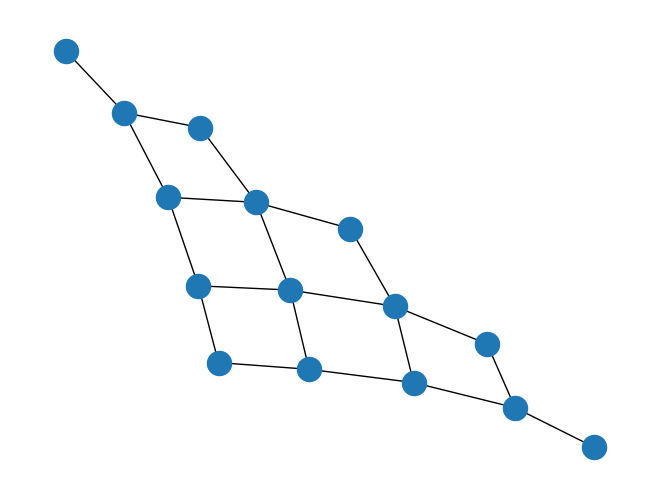

In [17]:
random_table = generate_random_table(2,3,15)
graph = graph_of_table(random_table)
layout = networkx.spring_layout(graph)
networkx.draw(graph,pos=layout)
plt.show()

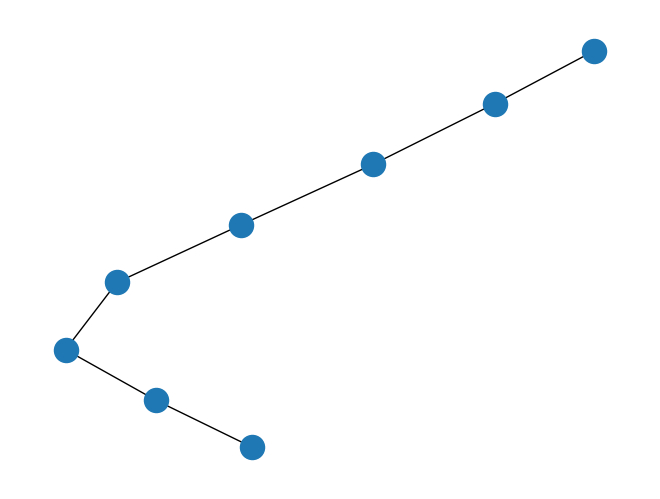

In [18]:
random_table = generate_random_table(2,2,15)
graph = graph_of_table(random_table)
layout = networkx.spring_layout(graph)
networkx.draw(graph,pos=layout)
plt.show()

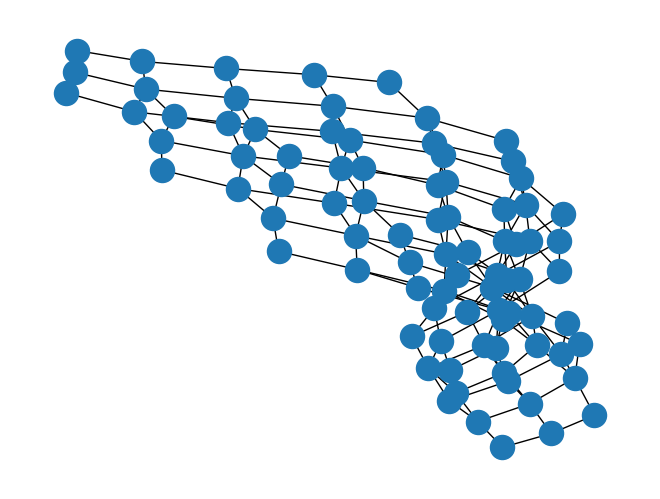

In [19]:
random_table = generate_random_table(2,4,18)
graph = graph_of_table(random_table)
layout = networkx.spring_layout(graph)
networkx.draw(graph,pos=layout)
plt.show()

TODO 1.4 (A faire à la maison): Calculer la $p$-value d'un tableau $N\times M$. Colorier les sommets du graphe selon la valeur de la $p$-value. Deux versions sont attendues:
- pour le seuil $0.05$, colorier en rouge les sommets représentant des tableaux non-significatif et en vert des sommets des tableaux significatifs.
- utiliser la $p$-value pour faire un degradé de couleurs.

## Test approché du $\chi^2$

TODO 1.5: Notez la définition présenté au tableau de la quantité statistique évaluée sur le tableau de contingence lors du test du $\chi^2$. Compléter la fonction calculant cette statistique.

In [22]:
def chi2_statistique(tableau,debug = False):
    n = max([x for (x,_) in tableau])
    m = min([y for (_,y) in tableau])
    res = 0
    N = tableau[(n,m)]
    for x in range(n):
        for y in range(m):
            exy = (tableau[(x,m)]/N)*(tableau[(n,y)]/N)*N
            result += (tableau[(x,y)] - exy)**2/exy
            if debug:
                print(f' (x = {x}, y = {y}), tableau[x,y] = {tableau[x,y]}, exy = {exy}')
    return res

chi2_statistique(tableau)

0

TODO 1.6: Calculer la distribution de cette statistique sur un tableau aléatoire à marginale fixée. Tracer la fonction cumulative empirique.

In [25]:
def chi2_statistique_distribution_all_tableaux_with_same_marginal(tableau):
    tab_same_marg = list_all_2x2_tableaux_with_same_marginals(tableau)
    probas = { hash_tableau(tab) : probability_of_a_tableau(tab)\
                    for tab in tab_same_marg }
    chi2values = { hash_tableau(tab) : chi2_statistique(tab)\
                 for tab in tab_same_marg }
    pairs_tableau_chi2value = [ (t,chi2values[t]) for t in chi2values ]
    pairs_tableau_chi2value.sort(key=lambda p:p[1])
    probability_found = 0
    cdf = [(0,0)]
    for i in range(len(pairs_tableau_chi2value)):
        (a_tableau, its_chi2_value) = pairs_tableau_chi2value[i]
        probability_found += probas[a_tableau]
        cdf += [(its_chi2_value, probability_found)]
    return cdf
cdf = chi2_statistique_distribution_all_tableaux_with_same_marginal(tableau)
print(cdf[-1])

(0, Fraction(1, 1))


La distribution $\chi^2_k$ est une loi de distribution codée par une fonction spéciale, avec un paramètre $k$, aussi nommé le degré de liberté.
__numpy__ propose un générateur de la distribution:

In [27]:
import numpy
import numpy.random

help(numpy.random.chisquare)

Help on built-in function chisquare:

chisquare(...) method of numpy.random.mtrand.RandomState instance
    chisquare(df, size=None)
    
    Draw samples from a chi-square distribution.
    
    When `df` independent random variables, each with standard normal
    distributions (mean 0, variance 1), are squared and summed, the
    resulting distribution is chi-square (see Notes).  This distribution
    is often used in hypothesis testing.
    
    .. note::
        New code should use the ``chisquare`` method of a ``default_rng()``
        instance instead; please see the :ref:`random-quick-start`.
    
    Parameters
    ----------
    df : float or array_like of floats
         Number of degrees of freedom, must be > 0.
    size : int or tuple of ints, optional
        Output shape.  If the given shape is, e.g., ``(m, n, k)``, then
        ``m * n * k`` samples are drawn.  If size is ``None`` (default),
        a single value is returned if ``df`` is a scalar.  Otherwise,
        ``

TODO 1.7: Tracer la fonction cumulative empirique pour le générateur avec un paramètre $k$ correspondant à $(N-1)\times (M-1)$ pour un tableau de taille $N\times M$. Comparer avec la fonction cumulative de la statistique __chi2_stastistique__ pour un tableau.

[]

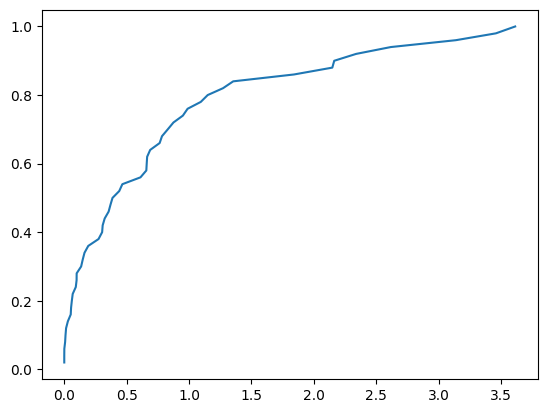

In [31]:
def empirical_cdf_of_chisquare_generator(k:int,nb_tosses:int)->List[Tuple[float, float]]:
    samples = [ numpy.random.chisquare(k) for _ in range(nb_tosses)]
    samples.sort()
    cdf = [ (samples[i], (i+1)/len(samples)) for i in range(len(samples)) ]
    return cdf

cdf2 = empirical_cdf_of_chisquare_generator(1,50)

x2s = [ p[0] for p in cdf2 ]
y2s = [ p[1] for p in cdf2 ]
plt.plot(x2s,y2s)
plt.plot()

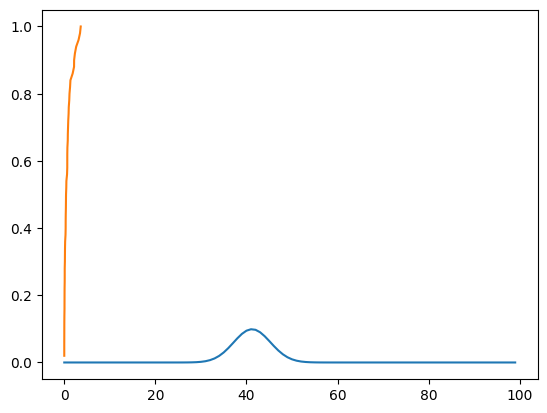

In [32]:
plt.plot(xs,ys)
plt.plot(x2s,y2s)
plt.show()

## La suite au tableau